[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hideaki-kyutech/softcomp2023/blob/main/fuzzy_inf_2023.ipynb)


# ファジィ推論

## 準備

### ファジィ推論パッケージ`UPA Fuzzy Systems`のインストール

In [3]:
!pip install UPAFuzzySystems

### パッケージのインポート

In [5]:
import numpy as np # 数値行列計算ライブラリ
import matplotlib.pyplot as plt # グラフ描画ライブラリ
import UPAFuzzySystems as UPAfs # ファジィ推論

## マムダニの推論法（min-max重心法）

### 問題設定：カーブと速度を考慮した車の加速ロジック
カーブと速度を考慮した車の加速ロジックをファジィ推論で実現する。この運転ロジックとして、次のような規則を仮定する。
<dl>
<dt>規則1</dt>
<dd>カーブが<u>急</u>で、速度が<u>小さい</u>ならば、アクセルを保持せよ（速度を<u>保持</u>せよ）</dd>
<dt>規則2</dt>
<dd>カーブが<u>急</u>で、速度が<u>大きい</u>ならば、ブレーキを踏め（<u>減速</u>せよ）</dd>
<dt>規則3</dt>
<dd>カーブが<u>緩やか</u>で、速度が<u>小さい</u>ならば、アクセルを踏み込め（<u>加速</u>せよ）</dd>
<dt>規則4</dt>
<dd>カーブが<u>緩やか</u>で、速度が<u>大きい</u>ならば、アクセルを保持せよ（速度を<u>保持</u>せよ）</dd>
</dl>
この4つの規則は言葉で書かれているので、このままではファジィ推論を実行することができない。そこで、上の言語規則の"急"、"緩やか"、"小さい"、"大きい"、"速度を保持せよ"、"減速せよ"、"加速せよ"などの推論情報として必要なものを、ファジィ集合として表現する必要がある。本例題では、これらのファジィ集合を次のようなメンバーシップ関数で定義する。



<img src="http://www.ssc.ecs.kyutech.ac.jp/store/img/mem_func1.png" width="400" alt="membership_function">

x: カーブ<br>
y: 速度<br>
z: 加速度（アクセルあるいはブレーキの操作）<br>
とし、それぞれに対する全体集合（ユニバース`universe`）を次のように定める。<br>
$$X= \{x|0\leq x \leq 180\}$$
$$Y= \{y|0\leq y \leq 100\}$$
$$Z= \{z|-2\leq z \leq 2\}$$

### メンバーシップ関数の設定

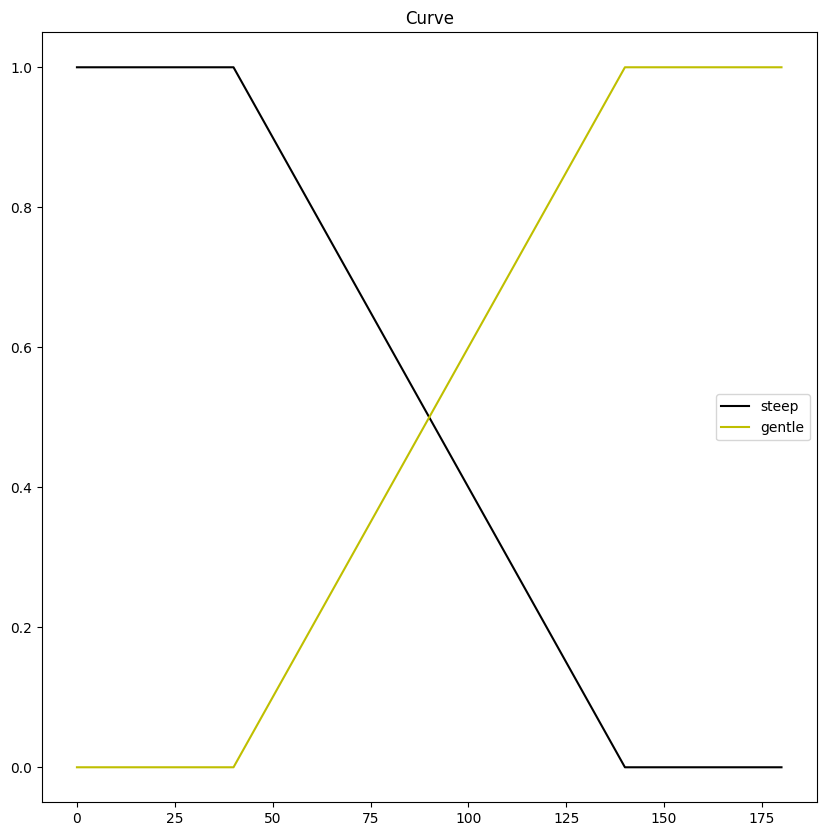

In [20]:
# カーブのメンバーシップ関数の作成
Curve = UPAfs.fuzzy_universe('Curve', np.arange(0,181,1), 'continuous') # ユニバースの設定
Curve.add_fuzzyset('steep','trapmf',[0,0,40,140])  # 台形型（trapezoidal）ファジィ集合[左下, 左上, 右上, 右下]
Curve.add_fuzzyset('gentle','trapmf',[40,140,180,1800]) # 台形型ファジィ集合
Curve.view_fuzzy() # 描画

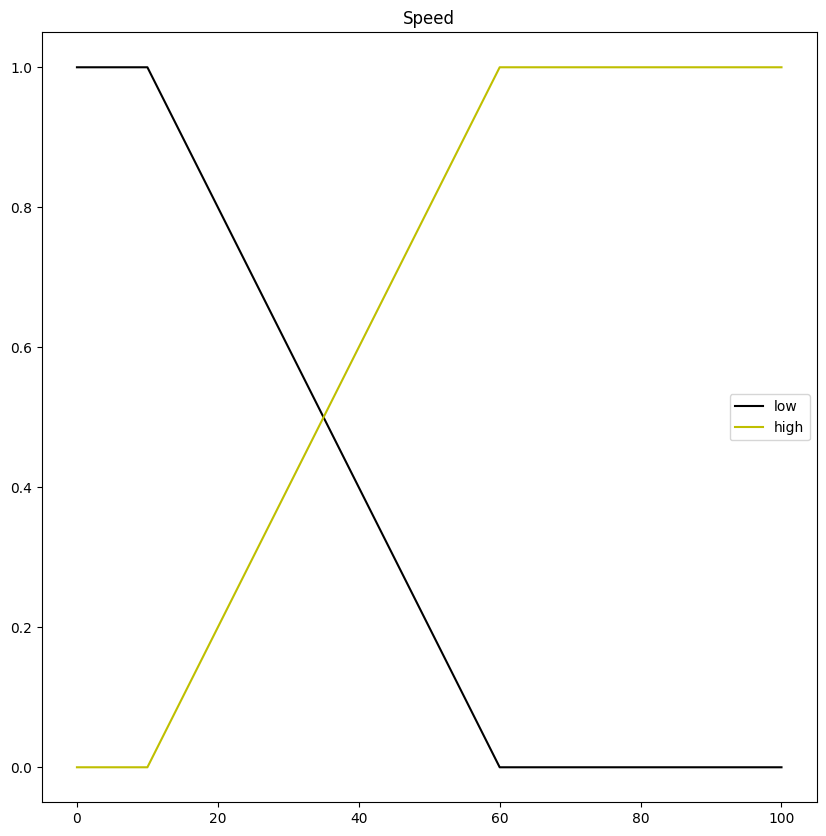

In [21]:
# 速度のファジィ集合
Speed = UPAfs.fuzzy_universe('Speed', np.arange(0,101,1), 'continuous')
Speed.add_fuzzyset('low','trapmf',[0,0,10,60])
Speed.add_fuzzyset('high','trapmf',[10,60,100,100])
Speed.view_fuzzy()

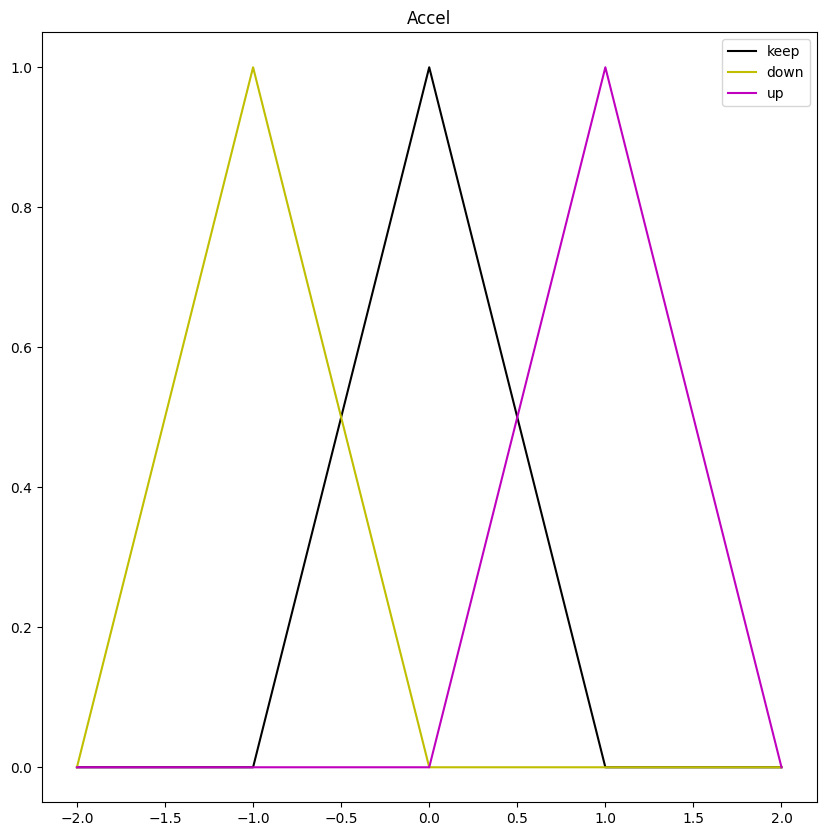

In [22]:
# 加速度のファジィ集合
Accel = UPAfs.fuzzy_universe('Accel', np.arange(-2,3,1), 'continuous')
Accel.add_fuzzyset('keep','trimf',[-1,0,1])
Accel.add_fuzzyset('down','trimf',[-2,-1,0])
Accel.add_fuzzyset('up','trimf',[0,1,2])
Accel.view_fuzzy()

### マムダニのファジィ推論システムの設定

In [13]:
Mamdani = UPAfs.inference_system('Mamdani')
Mamdani.add_premise(Curve)  # 前件部変数1
Mamdani.add_premise(Speed)     # 前件部変数2
Mamdani.add_consequence(Accel) # 後件部変数

Mamdani.add_rule([['Curve','steep'],['Speed','low']],['and'],[['Accel','keep']]) # 規則1
Mamdani.add_rule([['Curve','steep'],['Speed','high']],['and'],[['Accel','down']]) # 規則2
Mamdani.add_rule([['Curve','gentle'],['Speed','low']],['and'],[['Accel','up']]) # 規則3
Mamdani.add_rule([['Curve','gentle'],['Speed','high']],['and'],[['Accel','keep']]) # 規則4

Mamdani.configure('Mamdani')
Mamdani.build()

### システムの入出力関係の描画
起こりうる全ての入力（カーブと速度）に対する出力（加速度）の全体像を俯瞰して見るために、入力をX-Y面にとり、出力をZ軸とする3次元プロットを描画する。

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

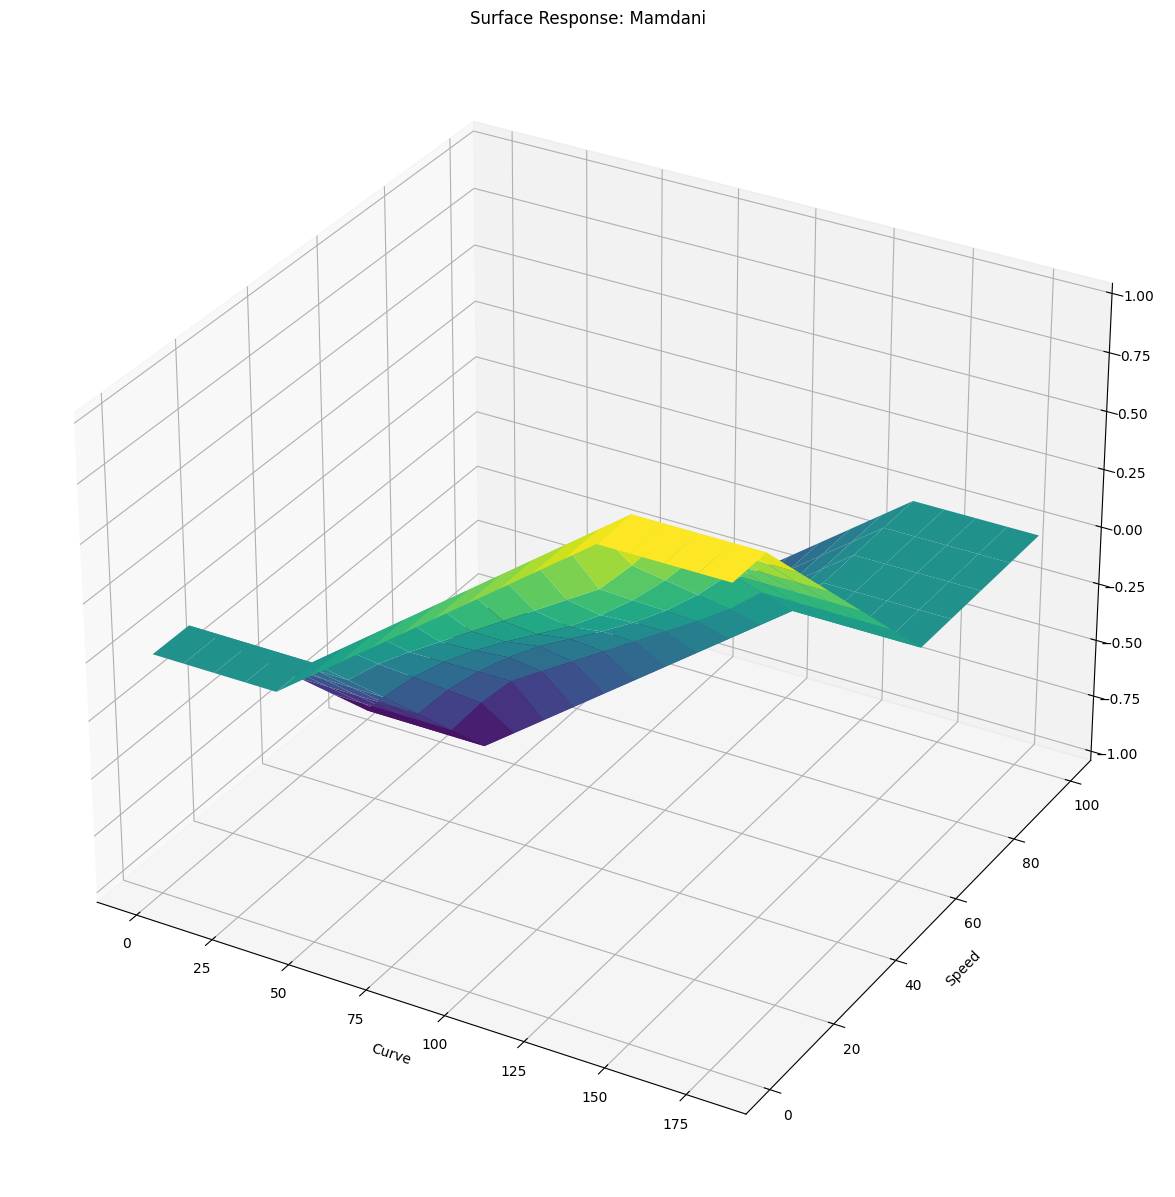

In [23]:
curve_values = np.arange(0,181,10)
speed_values = np.arange(0,101,10)

Mamdani.surface_fuzzy_system([curve_values,speed_values])

描画結果を見ると、入力と出力が非線形の関係になっていることがわかる。（線形なら平面）

### 特定の入力に対する推論結果
カーブ半径が60m、速度が時速50kmの入力に対する推論結果は次のようにして得られる。カーブ半径60mという入力は、"急"と"緩やか"を表すファジィ集合に対して、それぞれ0.8, 0.2のメンバーシップ値となる。そこで、カーブ半径60mの状況を言語的に表現するならば、"や急"となるだろう。同様に、速度50kmの状況を言語的に表現すれば、"やや速い"となる。この入力の状況をまとめると、"カーブ半径がやや急で、速度がやや速い"と表現できる。

In [17]:
Mamdani.fuzzy_system_sim([60,50])

array([[-0.5]])

推論結果は、$-0.5$となり、これを言語的に表現すれば、"やや減速せよ"と解釈できる。言語的に表現された入力状況と先に示された4つの言語規則を照らし合わせると、"やや減速せよ"という推論結果の妥当性がわかる。このように、ファジィ推論はいくつかの推論規則と与えられた入力を照らし合わせ、補間的な方法によって推論結果を導くことができる。

In [24]:
Mamdani.structure # システムの構成

{'Rules': [{'antecedent': [['trapmf',
     array([  0,   0,  40, 140]),
     array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
             26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
             39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
             52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
             65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
             78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
             91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
            104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
            117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
            130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
            143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
    

## 後件部に線形関数を用いる推論法（高木・菅野のファジィ推論）
マムダニの推論法でファジィ推論を行う場合、前件部変数が多くなると次のような問題が起こる。
1. 前件部変数が増えるたびに、規則数が指数関数的に増加する。
2. 規則数が増えると、規則作成の作業の手間が膨大になる。
3. 前件部変数が多くなると、一般に前件部変数と後件部変数との間の因果関係を捉えることが難しくなり、規則を作成することも難しくなる。

これらの問題を解決するために考え出されたのが、後件部に線形関数を用いる推論法である。この推論法の大きな特徴は、

1. 規則の後件部に線形の入出力関係式を用いている。
2. 入出力データを用いたモデリングによって推論規則を同定する。
3. 直説法に比べて、少ない規則数になる。



### 問題設定：2つのセンサによるヒーターのスイッチ調整
次のような直接法の推論規則を仮定する。ここで、xはセンサ1の大きさ、yはセンサ2の大きさ、zはスイッチの設定を表すものとする。
1. IF x is "Small" and y is "Small" THEN z is "Medium"
2. IF x is "Small" and y is "Medium" THEN z is "Small"
3. IF x is "Small" and y is "Big" THEN z is "Very Small"
4. IF x is "Medium" and y is "Small" THEN z is "Big"
5. IF x is "Medium" and y is "Medium" THEN z is "Medium"
6. IF x is "Medium" and y is "Big" THEN z is "Small"
7. IF x is "Big" and y is "Small" THEN z is "Very Big"
8. IF x is "Big" and y is "Medium" THEN z is "Medium"
9. IF x is "Big" and y is "Big" THEN z is "Very Small"

数値的な設定は、"Very Small"="約2", "Small"="約4", "Medium"="約6", "Big"="約8", "Very Big"="約10"とする。


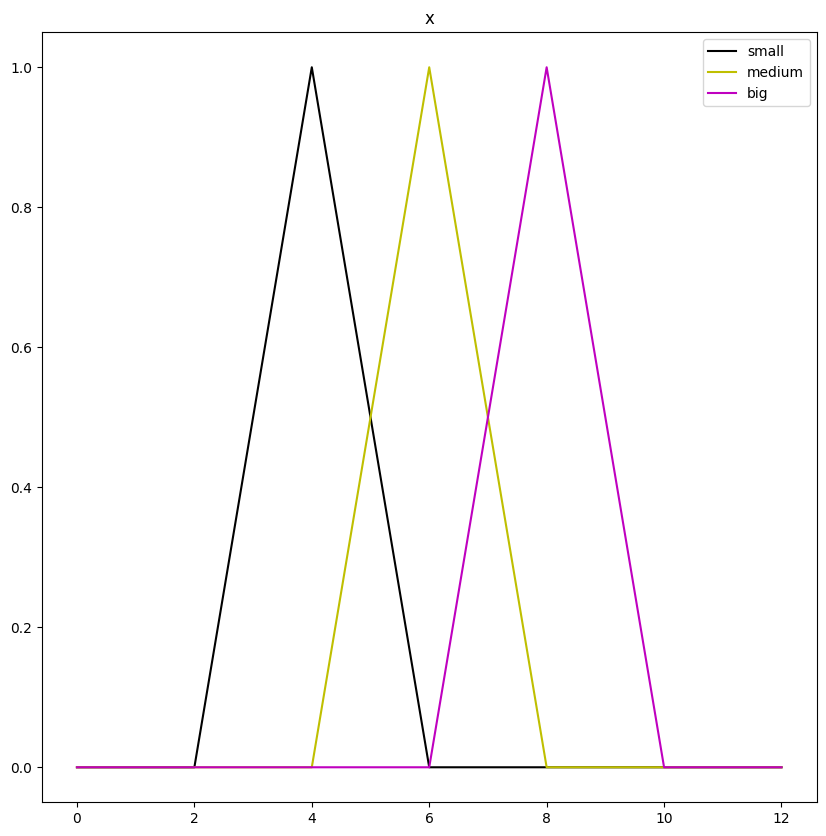

In [25]:
# xのメンバシップ関数の設定
x = UPAfs.fuzzy_universe('x', np.arange(0,13,1), 'continuous')
x.add_fuzzyset('small','trimf',[2,4,6])     # Small
x.add_fuzzyset('medium','trimf',[4,6,8])     # Medium
x.add_fuzzyset('big','trimf',[6,8,10])    # Big

x.view_fuzzy()

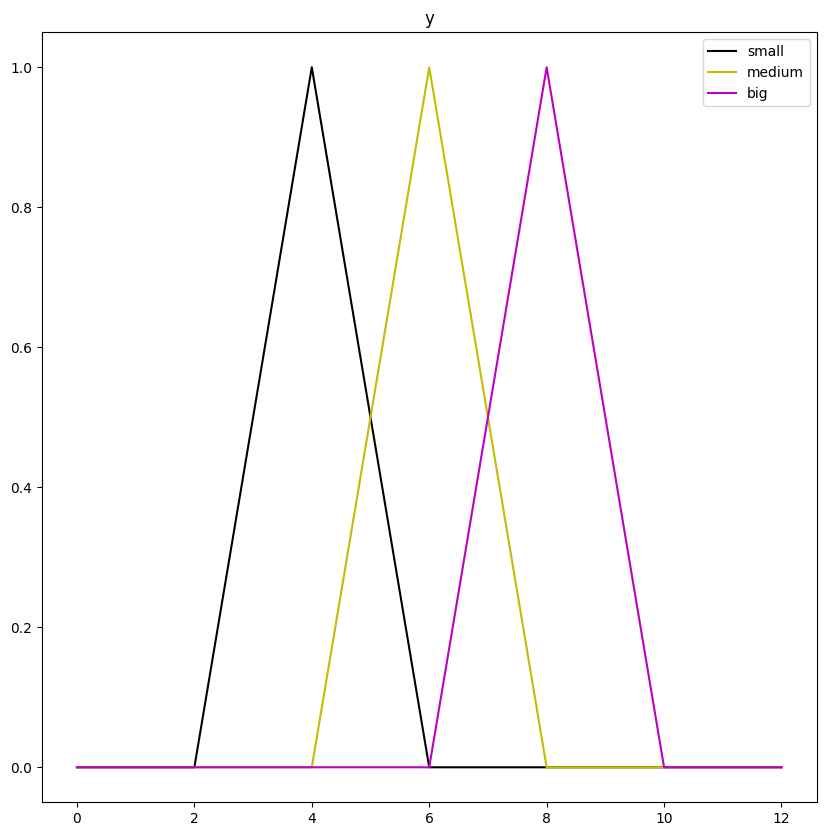

In [32]:
# yのメンバシップ関数の設定
y = UPAfs.fuzzy_universe('y', np.arange(0,13,1), 'continuous')
y.add_fuzzyset('small','trimf',[2,4,6])     # Small
y.add_fuzzyset('medium','trimf',[4,6,8])     # Medium
y.add_fuzzyset('big','trimf',[6,8,10])    # Big

y.view_fuzzy()

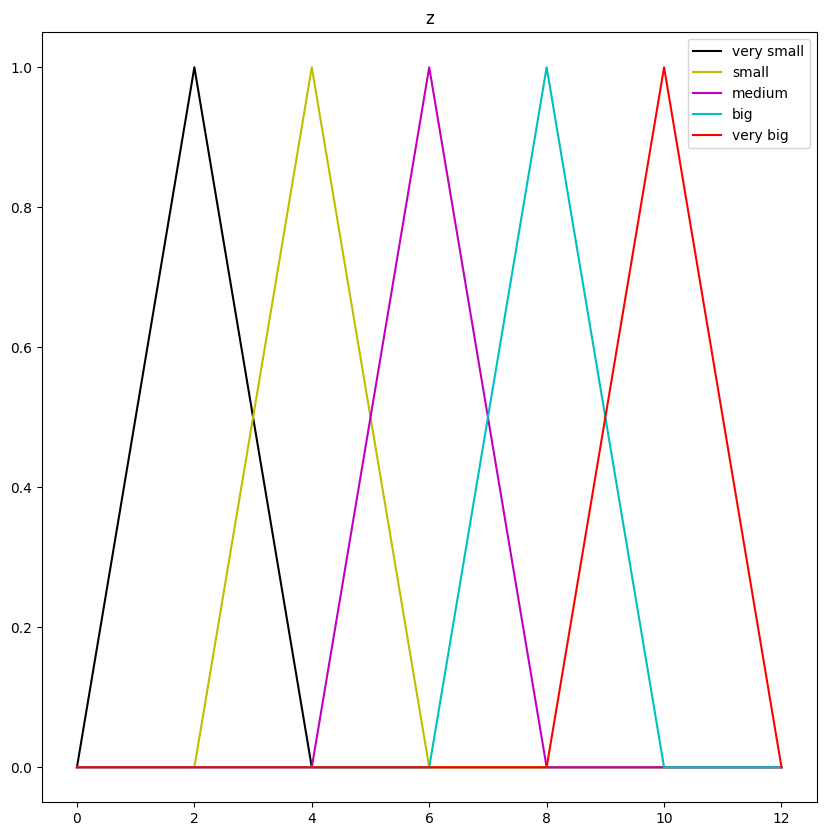

In [33]:
# zのメンバシップ関数の設定
z = UPAfs.fuzzy_universe('z', np.arange(0,13,1), 'continuous')
z.add_fuzzyset('very small','trimf',[0,2,4])    # Very Small
z.add_fuzzyset('small','trimf',[2,4,6])     # Small
z.add_fuzzyset('medium','trimf',[4,6,8])     # Medium
z.add_fuzzyset('big','trimf',[6,8,10])    # Big
z.add_fuzzyset('very big','trimf',[8,10,12])  # Very Big

z.view_fuzzy()

In [34]:
Mamdani2 = UPAfs.inference_system('Mamdani')
Mamdani2.add_premise(x)  # 前件部1
Mamdani2.add_premise(y)     # 前件部2
Mamdani2.add_consequence(z) # 後件部

Mamdani2.add_rule([['x','small'],['y','small']],['and'],[['z','medium']])  # 規則1
Mamdani2.add_rule([['x','small'],['y','medium']],['and'],[['z','small']])  # 規則2
Mamdani2.add_rule([['x','small'],['y','big']],['and'],[['z','very small']]) # 規則3
Mamdani2.add_rule([['x','medium'],['y','small']],['and'],[['z','big']])  # 規則4
Mamdani2.add_rule([['x','medium'],['y','medium']],['and'],[['z','medium']])  # 規則5
Mamdani2.add_rule([['x','medium'],['y','big']],['and'],[['z','small']])  # 規則6
Mamdani2.add_rule([['x','big'],['y','small']],['and'],[['z','very big']]) # 規則7
Mamdani2.add_rule([['x','big'],['y','medium']],['and'],[['z','medium']])  # 規則8
Mamdani2.add_rule([['x','big'],['y','big']],['and'],[['z','very small']]) # 規則9

Mamdani2.configure('Mamdani')
Mamdani2.build()

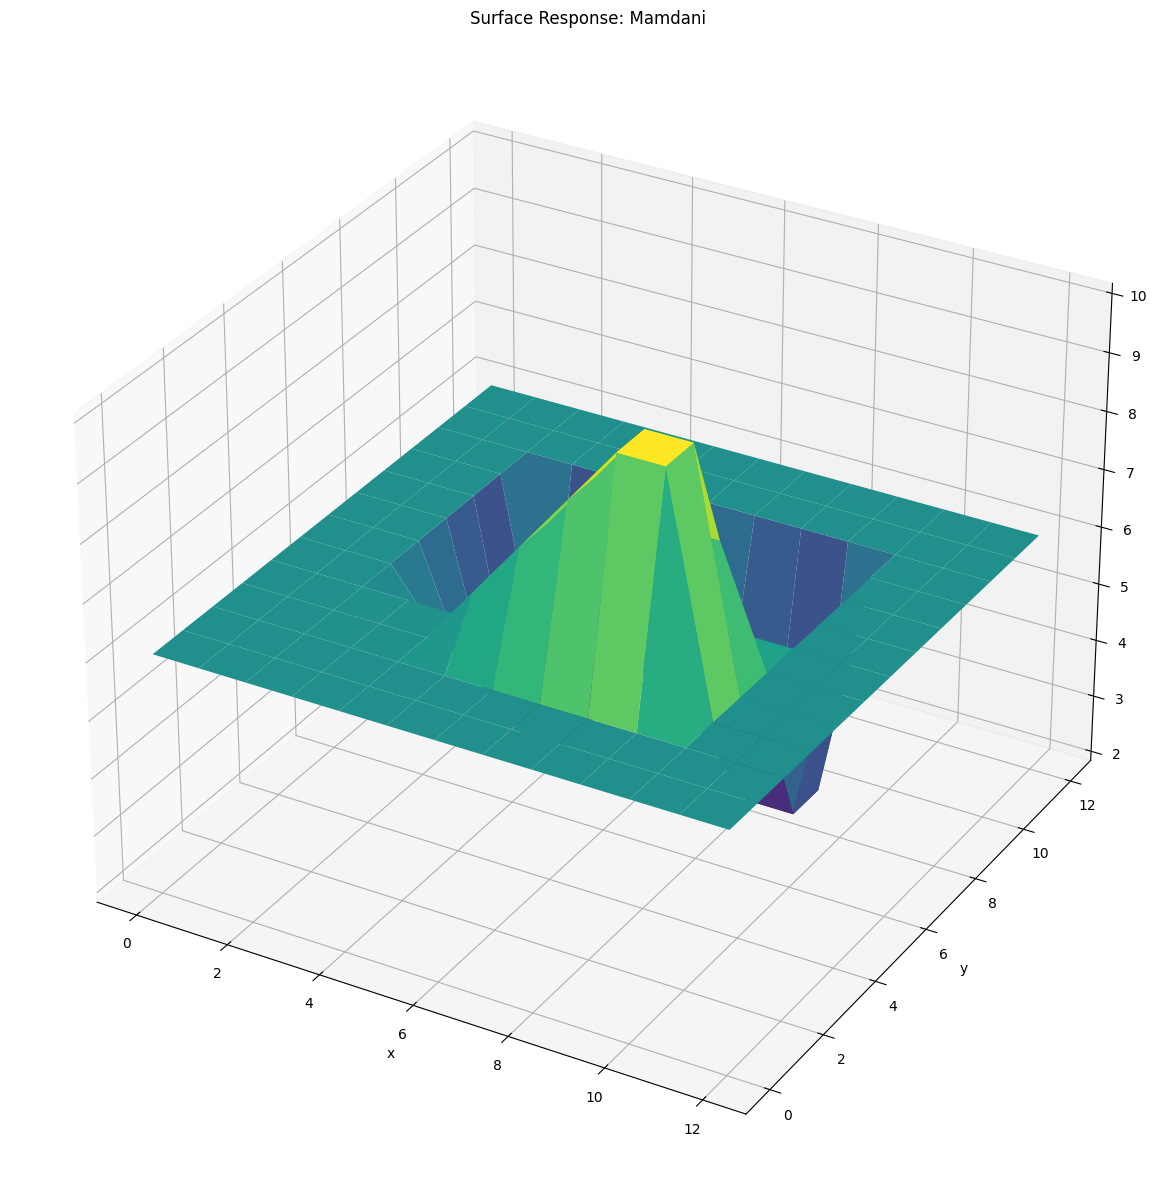

In [35]:
vol_values = np.arange(0,13,1)

Mamdani2.surface_fuzzy_system([vol_values,vol_values])

x=7, y=5の時の推論結果

In [36]:
Mamdani2.fuzzy_system_sim([7,5])

array([[8.]])

<img src="http://www.ssc.ecs.kyutech.ac.jp/store/img/takagi_sugeno.png" width="800" alt="membership_function">

In [37]:
x = UPAfs.fuzzy_universe('x', np.arange(0,13,1), 'continuous')
x.add_fuzzyset('sm','trapmf',[0,0,6,8])     # Small or Medium
x.add_fuzzyset('b','trapmf',[6,8,12,12])        # Big

z = UPAfs.fuzzy_universe('z', np.arange(0,13,1), 'continuous')
z.add_fuzzyset('r1','eq','-2*x[1]+18')    # rule1
z.add_fuzzyset('r2','eq','x[0]-x[1]+6')   # rule2

Sugeno = UPAfs.inference_system('Sugeno')
Sugeno.add_premise(x)
Sugeno.add_premise(y)
Sugeno.add_consequence(z)

Sugeno.add_rule([['x','b']],[],[['z','r1']])  # 規則1
Sugeno.add_rule([['x','sm']],[],[['z','r2']])  # 規則1

Sugeno.configure('Sugeno')
Sugeno.build()

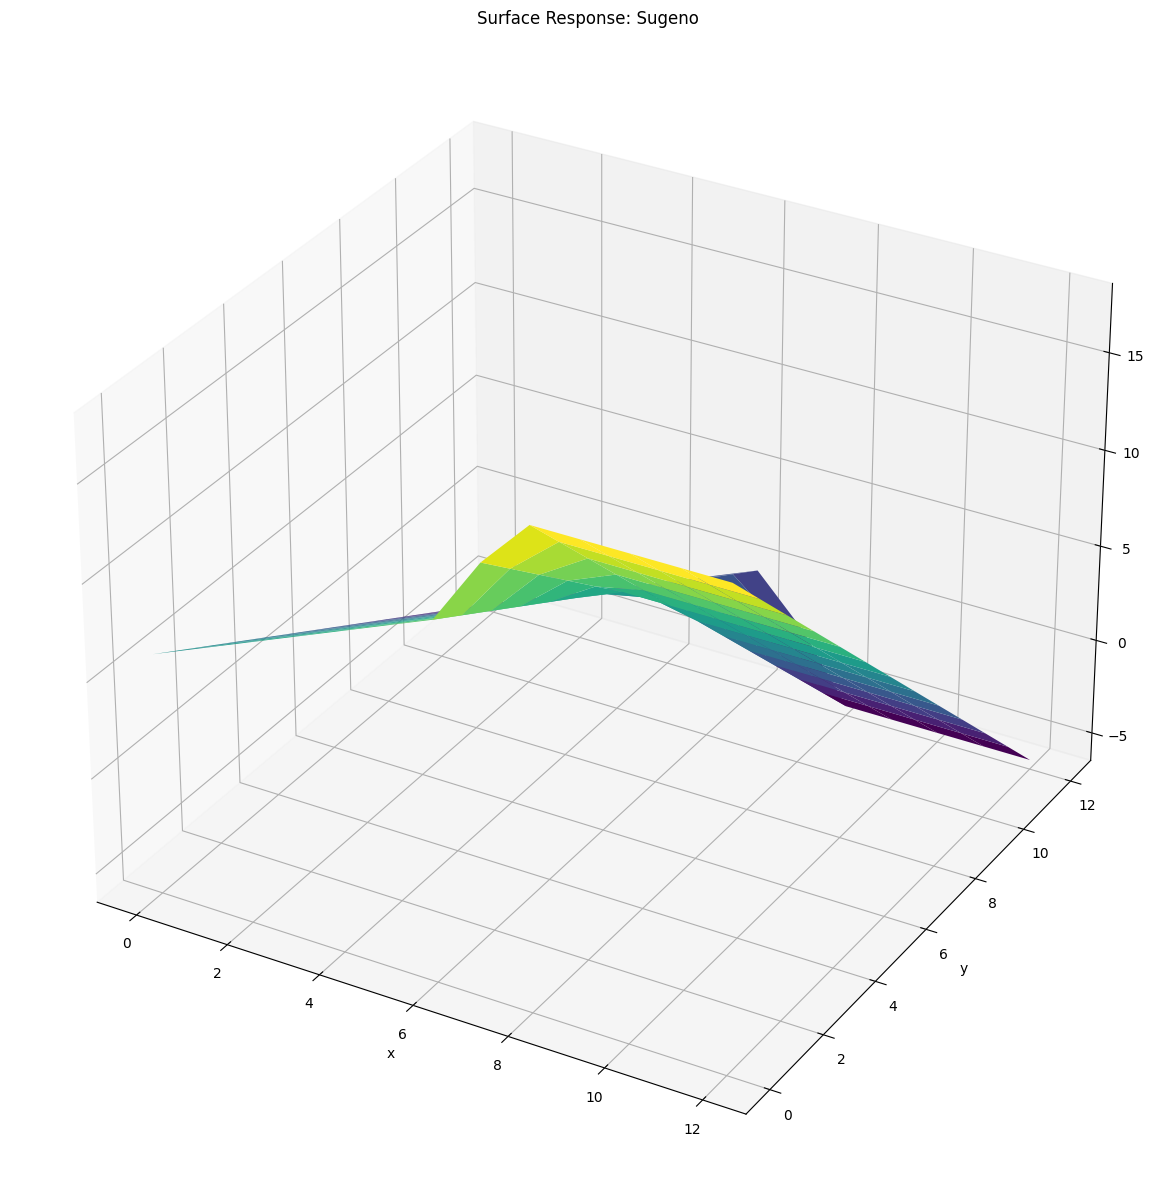

In [38]:
vol_values = np.arange(0,13,1)

Sugeno.surface_fuzzy_system([vol_values,vol_values])

In [39]:
Sugeno.fuzzy_system_sim([7,5])

array([[8.]])

## 簡略型ファジィ推論法

マムダニの推論法で取り上げた問題設定において、後件部の加速度をファジィ集合ではなく、確定値（シングルトン）とすると、簡略型ファジィ推論になる。

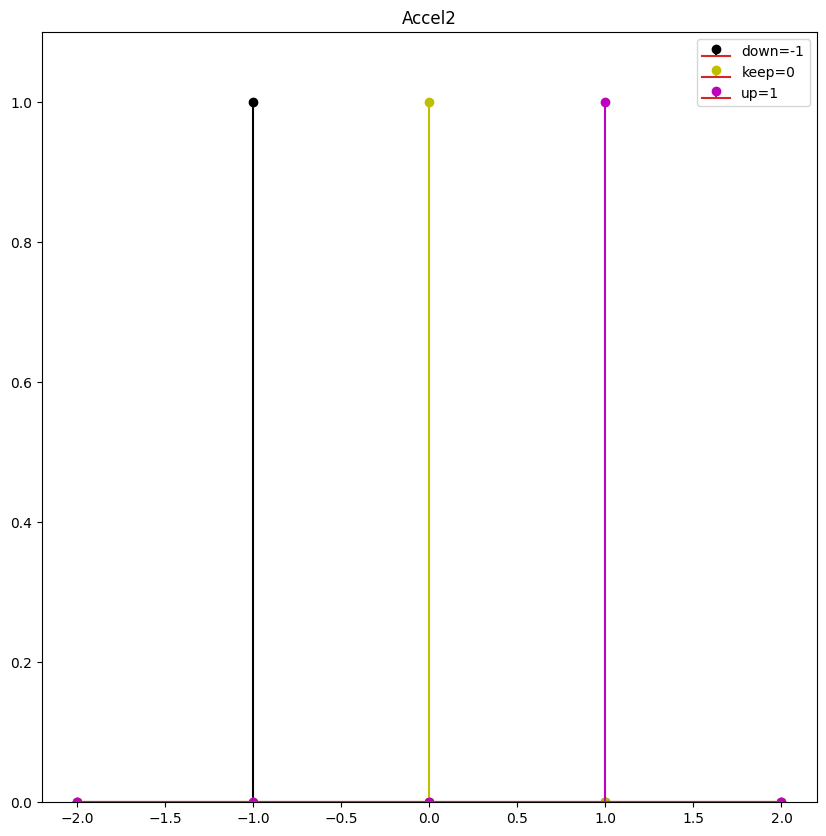

In [40]:
#Output Fuzzy Sets
Accel2 = UPAfs.fuzzy_universe('Accel2', np.arange(-2,3,1), 'continuous')
Accel2.add_fuzzyset('down','eq','-1')
Accel2.add_fuzzyset('keep','eq','0')
Accel2.add_fuzzyset('up','eq','1')

Accel2.view_fuzzy()

In [42]:
#Defining Rules and Building Inference System
Linear1 = UPAfs.inference_system('Linear')
Linear1.add_premise(Curve)
Linear1.add_premise(Speed)
Linear1.add_consequence(Accel2)

Linear1.add_rule([['Curve','steep'],['Speed','low']],['and'],[['Accel2','keep']]) # rule1
Linear1.add_rule([['Curve','steep'],['Speed','high']],['and'],[['Accel2','down']]) # rule2
Linear1.add_rule([['Curve','gentle'],['Speed','low']],['and'],[['Accel2','up']]) #rule3
Linear1.add_rule([['Curve','gentle'],['Speed','high']],['and'],[['Accel2','keep']]) #rule4

Linear1.configure('Linear')
Linear1.build()

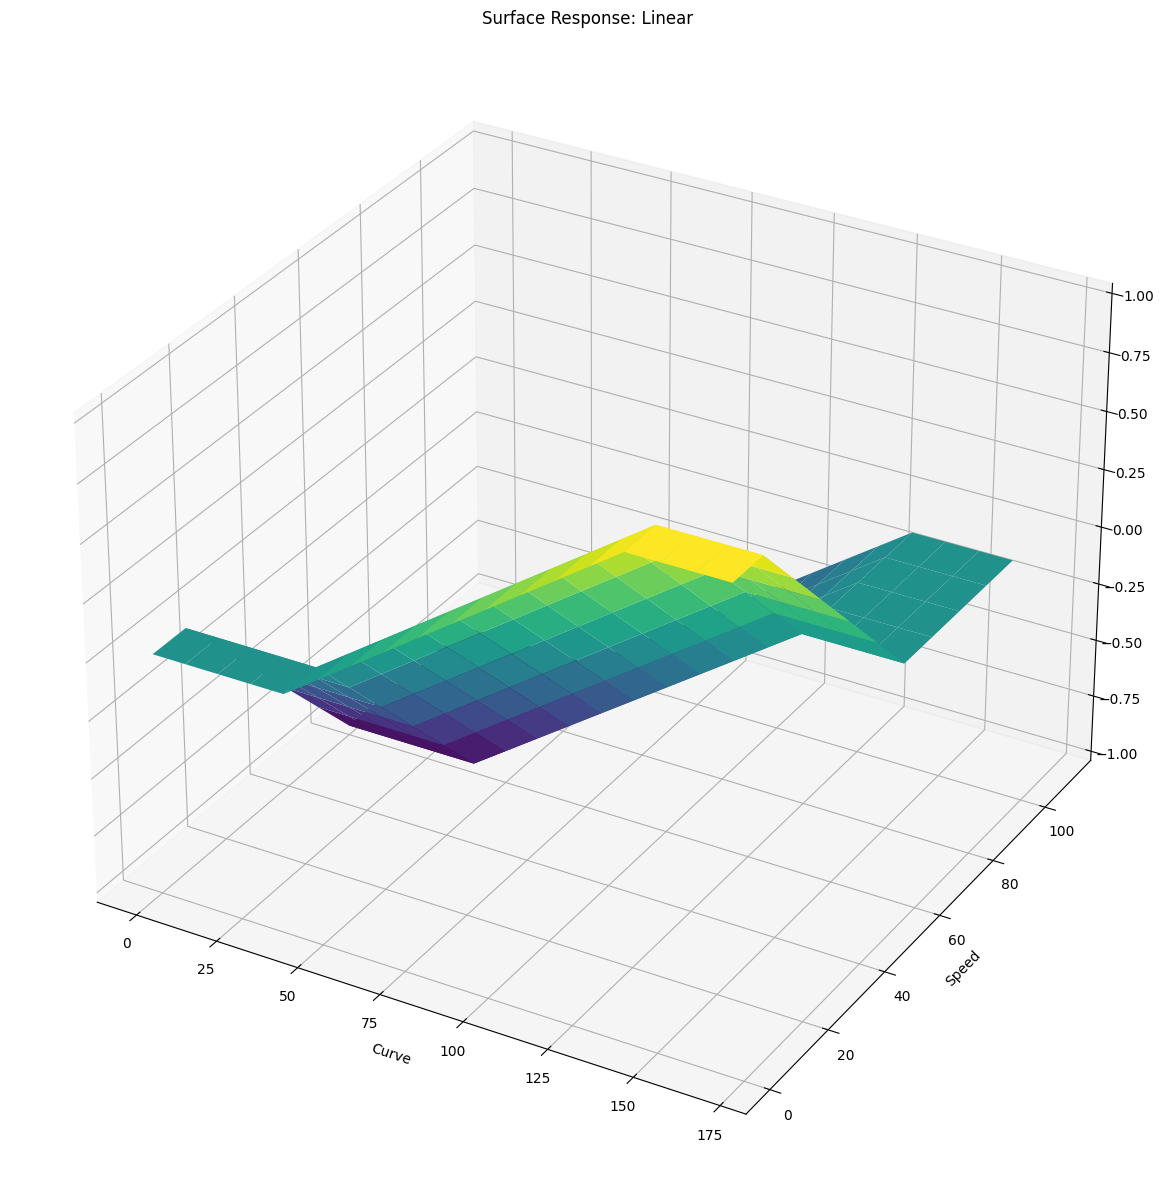

In [47]:
curve_values = np.arange(0,180,10)
speed_values = np.arange(0,120,10)

Linear1.surface_fuzzy_system([curve_values,speed_values])

In [44]:
Linear1.fuzzy_system_sim([10,70])

array([[-1.]])

In [45]:
Linear1.fuzzy_system_sim([60,50])

array([[-0.6]])

In [46]:
Linear1.fuzzy_system_sim([30,30])

array([[-0.4]])